In [1]:
import itertools, time, os, gc, shutil, uuid, shutil, pickle, lzma, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KDTree, BallTree

import geopandas as gpd
import shapely 
import pygeos
import rasterio
import pyproj

/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


##### Create a 2d grid with NumPy as an array of 4 dimenions: xmin, ymin, xmax, ymax.
- The xmin, xmax, ymin, ymax parameters define the bounds of the grid.
- The parameters xstep and ystep define the number of rectangles in the x-axis and y-axis respectively.
- The index of the grid is also returned.
- Every operation is vectorized and implemented in NumPy so it should be very efficient.

In [2]:
def create_grid(xmin, xmax, ymin, ymax, xstep, ystep):
    
    # Generate two evenly spaced ranges
    x = np.linspace(xmin, xmax, int(xstep+1))
    y = np.linspace(ymin, ymax, int(ystep+1))
    
    # Get center points for each range
    x = np.mean((x[1:], x[:-1]), axis=0)
    y = np.mean((y[1:], y[:-1]), axis=0)
    
    # Cartesian product of both ranges 
    x, y = np.meshgrid(x, y)
    x, y = x.ravel(), y.ravel()

    # Calculate increment to get the 4 bounds
    xd = (xmax - xmin) / (xstep * 2)
    yd = (ymax - ymin) / (ystep * 2)
    
    # Repeat center points and add respective increment
    grid = np.column_stack((x,y))
    grid = np.tile(grid, 2) + np.array([[-xd, -yd, xd, yd]])
    
    # Generate index
    grid_index = np.arange(1, xstep * ystep + 1)

    return grid, grid_index


##### Examples:

- Generate 5x5 grid.
- Load as Shapely polygons.
- Plot with GeoPandas.

In [3]:
grid, grid_index = create_grid(xmin=0, xmax=10, ymin=0, ymax=10, xstep=5, ystep=5)

In [4]:
grid

array([[ 0.,  0.,  2.,  2.],
       [ 2.,  0.,  4.,  2.],
       [ 4.,  0.,  6.,  2.],
       [ 6.,  0.,  8.,  2.],
       [ 8.,  0., 10.,  2.],
       [ 0.,  2.,  2.,  4.],
       [ 2.,  2.,  4.,  4.],
       [ 4.,  2.,  6.,  4.],
       [ 6.,  2.,  8.,  4.],
       [ 8.,  2., 10.,  4.],
       [ 0.,  4.,  2.,  6.],
       [ 2.,  4.,  4.,  6.],
       [ 4.,  4.,  6.,  6.],
       [ 6.,  4.,  8.,  6.],
       [ 8.,  4., 10.,  6.],
       [ 0.,  6.,  2.,  8.],
       [ 2.,  6.,  4.,  8.],
       [ 4.,  6.,  6.,  8.],
       [ 6.,  6.,  8.,  8.],
       [ 8.,  6., 10.,  8.],
       [ 0.,  8.,  2., 10.],
       [ 2.,  8.,  4., 10.],
       [ 4.,  8.,  6., 10.],
       [ 6.,  8.,  8., 10.],
       [ 8.,  8., 10., 10.]])

- Plot grid with Shapely, GeoPandas and PyPlot.

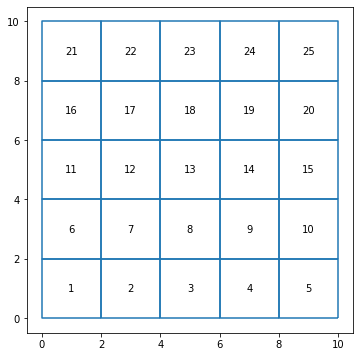

In [5]:
grid_shapely = list(map(lambda x: shapely.geometry.box(*x), grid))

fig, ax = plt.subplots(figsize=(6,6))

gpd.GeoDataFrame(geometry=grid_shapely).exterior.plot(ax=ax)

for coos, index in zip(grid, grid_index):
    ax.text(coos[[0,2]].mean(), coos[[1,3]].mean(), str(index), horizontalalignment='center', verticalalignment='center')

- Generate 10x5 grid.

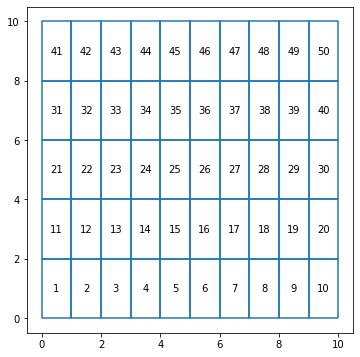

In [6]:
grid, grid_index = create_grid(xmin=0, xmax=10, ymin=0, ymax=10, xstep=10, ystep=5)

grid_shapely = list(map(lambda x: shapely.geometry.box(*x), grid))

fig, ax = plt.subplots(figsize=(6,6))

gpd.GeoDataFrame(geometry=grid_shapely).exterior.plot(ax=ax)

for coos, index in zip(grid, grid_index):
    ax.text(coos[[0,2]].mean(), coos[[1,3]].mean(), str(index), horizontalalignment='center', verticalalignment='center')

- Generate 5x10 grid.

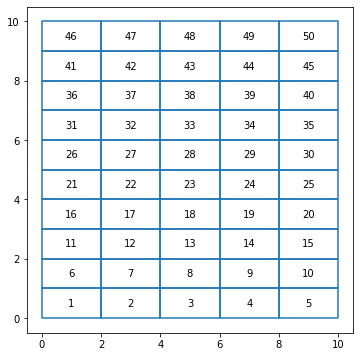

In [7]:
grid, grid_index = create_grid(xmin=0, xmax=10, ymin=0, ymax=10, xstep=5, ystep=10)

grid_shapely = list(map(lambda x: shapely.geometry.box(*x), grid))

fig, ax = plt.subplots(figsize=(6,6))

gpd.GeoDataFrame(geometry=grid_shapely).exterior.plot(ax=ax)

for coos, index in zip(grid, grid_index):
    ax.text(coos[[0,2]].mean(), coos[[1,3]].mean(), str(index), horizontalalignment='center', verticalalignment='center')

- Generate 1x1 grid.

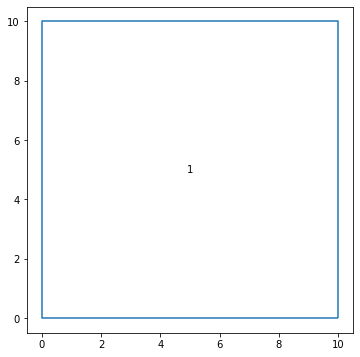

In [8]:
grid, grid_index = create_grid(xmin=0, xmax=10, ymin=0, ymax=10, xstep=1, ystep=1)

grid_shapely = list(map(lambda x: shapely.geometry.box(*x), grid))

fig, ax = plt.subplots(figsize=(6,6))

gpd.GeoDataFrame(geometry=grid_shapely).exterior.plot(ax=ax)

for coos, index in zip(grid, grid_index):
    ax.text(coos[[0,2]].mean(), coos[[1,3]].mean(), str(index), horizontalalignment='center', verticalalignment='center')

##### Bonus: load grid in PyGeos

In [9]:
grid, grid_index = create_grid(xmin=0, xmax=10, ymin=0, ymax=10, xstep=5, ystep=5)

In [10]:
grid_pygeos = pygeos.creation.box(*grid.T)

In [11]:
grid_pygeos

array([<pygeos.Geometry POLYGON ((2 0, 2 2, 0 2, 0 0, 2 0))>,
       <pygeos.Geometry POLYGON ((4 0, 4 2, 2 2, 2 0, 4 0))>,
       <pygeos.Geometry POLYGON ((6 0, 6 2, 4 2, 4 0, 6 0))>,
       <pygeos.Geometry POLYGON ((8 0, 8 2, 6 2, 6 0, 8 0))>,
       <pygeos.Geometry POLYGON ((10 0, 10 2, 8 2, 8 0, 10 0))>,
       <pygeos.Geometry POLYGON ((2 2, 2 4, 0 4, 0 2, 2 2))>,
       <pygeos.Geometry POLYGON ((4 2, 4 4, 2 4, 2 2, 4 2))>,
       <pygeos.Geometry POLYGON ((6 2, 6 4, 4 4, 4 2, 6 2))>,
       <pygeos.Geometry POLYGON ((8 2, 8 4, 6 4, 6 2, 8 2))>,
       <pygeos.Geometry POLYGON ((10 2, 10 4, 8 4, 8 2, 10 2))>,
       <pygeos.Geometry POLYGON ((2 4, 2 6, 0 6, 0 4, 2 4))>,
       <pygeos.Geometry POLYGON ((4 4, 4 6, 2 6, 2 4, 4 4))>,
       <pygeos.Geometry POLYGON ((6 4, 6 6, 4 6, 4 4, 6 4))>,
       <pygeos.Geometry POLYGON ((8 4, 8 6, 6 6, 6 4, 8 4))>,
       <pygeos.Geometry POLYGON ((10 4, 10 6, 8 6, 8 4, 10 4))>,
       <pygeos.Geometry POLYGON ((2 6, 2 8, 0 8, 0 6, 2 6))>,